In [25]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from skpsl import ProbabilisticScoringList

In [26]:
folder = Path("experiments/data/thyroid")
# folder = Path("data/thyroid")

names = ["age",
"sex",
"on_thyroxine",
"query_on_thyroxine",
"on_antithyroid_medication",
"sick",
"pregnant",
"thyroid_surgery",
"I131_treatment",
"query_hypothyroid",
"query_hyperthyroid",
"lithium",
"goitre",
"tumor",
"hypopituitary",
"psych",
"TSH",
"T3",
"TT4",
"T4U","FTI","class"]

# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)

# remove hypothyroid patients
data_thyroid_train = data_thyroid_train[data_thyroid_train["class"] > 1]
data_thyroid_test = data_thyroid_test[data_thyroid_test["class"] > 1] 

# drop FTI as in original paper by Turney
data_thyroid_train = data_thyroid_train.drop(columns="FTI")
data_thyroid_test = data_thyroid_test.drop(columns="FTI")

X_train, y_train = data_thyroid_train.iloc[:,:-1].to_numpy(), data_thyroid_train.iloc[:,-1].to_numpy()
X_test, y_test = data_thyroid_test.iloc[:,:-1].to_numpy(), data_thyroid_test.iloc[:,-1].to_numpy()

# convert y to 0,1 where 0 is normal and 1 hyperthyroid
y_train, y_test = 1 - (y_train -2), 1 - (y_test - 2)

# X = np.concatenate((X_train, X_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

C:\Users\jonas\AppData\Local\Temp\ipykernel_16128\1708211833.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
C:\Users\jonas\AppData\Local\Temp\ipykernel_16128\1708211833.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)


In [27]:
costs_thyroid = pd.read_csv("experiments/data/thyroid/ann-thyroid.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_thyroid[1] = costs_thyroid[1].str.strip(",").astype(float)

In [28]:
#lr = LogisticRegression().fit(X_train, y_train)
#xgb = XGBClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(X_train, y_train)
psl = ProbabilisticScoringList(score_set={-3,-2,-1,1,2,3}, method="brute").fit(X_train,y_train)

In [29]:
def get_thyroid_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    group_a = [16,17,18,19]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            discount = False
            if s in group_a:
                if discount:
                    cost += float(costs_thyroid.iloc[s,1])
                else:
                    cost += float(costs_thyroid.iloc[s,0])
            else:
                cost += 1
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_thyroid_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

In [30]:
def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf
            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists

def psl_limited_feature_predict(psl, X, max_features):
    predictions = []   
    feature_lists = []

    for row in X:
        p, k = None,None
        for k in range(max_features+1):
            p = psl[k].predict_proba([row])
            if entropy(p.squeeze(),base=2) == 0:
                break
        predictions.append(p)
        feature_lists.append(psl.features[:k])

    return np.vstack(predictions), feature_lists

In [31]:
briers_psl = []
briers_dt = []

accs_psl = []
accs_dt = []

baccs_psl = []
baccs_dt = []

costs_psl = []
costs_dt = []

num_features = X_train.shape[1]

for i in range(num_features):
#    y_prob_psl = psl.predict_proba(X_test, k=i)
#    psl_cost = len(X_test) * get_thyroid_cost_for_feature_subset(psl[i].features)

    y_prob_psl, used_features_psl = psl_limited_feature_predict(psl, X_test, max_features=i)
    psl_cost = sum(map(get_thyroid_cost_for_feature_subset,used_features_psl))

    y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)
    dt_cost = sum(map(get_thyroid_cost_for_feature_subset,used_features))

    briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
    briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

    accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    costs_psl.append(psl_cost)
    costs_dt.append(dt_cost)


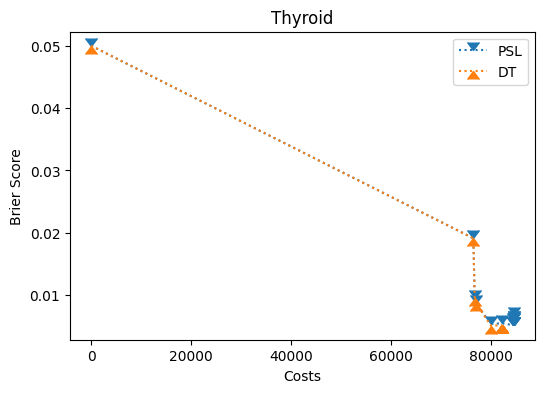

In [41]:
plt.figure(figsize=(5,3.5))
plt.plot(costs_psl, briers_psl, label="PSL", marker=7, ls=":", markersize=8)
plt.plot(costs_dt, briers_dt, label="DT", marker=6, ls=":", markersize=8)

plt.xlabel("Costs")
plt.ylabel("Brier Score")

plt.legend()
plt.title("Thyroid")
plt.savefig("brier_psl_dt_thyroid.pdf")

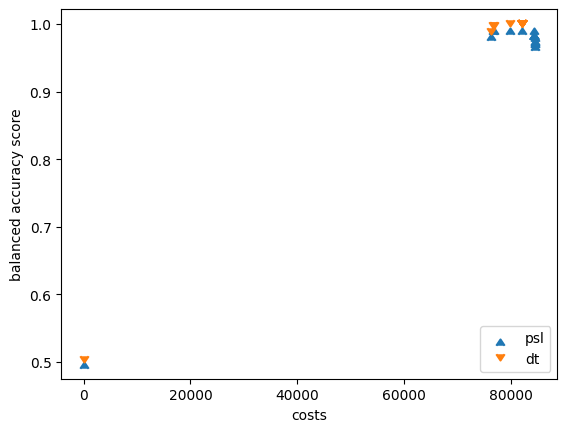

In [33]:
plt.scatter(costs_psl, baccs_psl, label="psl", marker=6)
plt.scatter(costs_dt, baccs_dt, label="dt", marker=7)

plt.xlabel("costs")
plt.ylabel("balanced accuracy score")

plt.legend(loc="lower right")
plt.show()

In [22]:
for k, pss in enumerate(psl):
    print(f"stage: {k} expected entropy {pss.score(X_train, y_train)}")

stage: 0 expected entropy 0.29448207867432064
stage: 1 expected entropy 0.06399908288744366
stage: 2 expected entropy 0.030353462780134018
stage: 3 expected entropy 0.02107280334623191
stage: 4 expected entropy 0.009128725962847506
stage: 5 expected entropy 0.006072111369206643
stage: 6 expected entropy 0.00354594907224526
stage: 7 expected entropy 0.001595224172782433
stage: 8 expected entropy 0.001595224172782433
stage: 9 expected entropy 0.001595224172782433
stage: 10 expected entropy 0.001595224172782433
stage: 11 expected entropy 0.001595224172782433
stage: 12 expected entropy 0.001595224172782433
stage: 13 expected entropy 0.001595224172782433
stage: 14 expected entropy 0.0016130550093206722
stage: 15 expected entropy 0.0017572726118045554
stage: 16 expected entropy 0.00499720045120511
stage: 17 expected entropy 0.0076904091130727496
stage: 18 expected entropy 0.016811983091075587
stage: 19 expected entropy 0.023990133439977267
stage: 20 expected entropy 0.0326117296303959


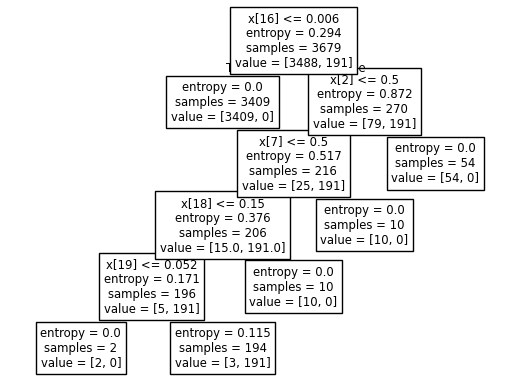

In [23]:
plot_tree(dt)
dt.tree_

In [24]:
psl.inspect()

,Stage,Threshold,Feature Index,Score,T = -31,T = -30,T = -29,T = -28,T = -27,T = -26,...,T = -3,T = -2,T = -1,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.051916,NaN,NaN,NaN,NaN,NaN,NaN
1,1,>0.0060,16.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,0.707407,NaN,NaN,NaN
2,2,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,0.884259,NaN,NaN,NaN
3,3,NaN,7.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,0.927184,NaN,NaN,NaN
4,4,>0.1485,18.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,0.974490,NaN,NaN,NaN
5,5,>0.0475,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.984536
6,6,>0.0235,17.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.000000,0.0,NaN,0.000000,0.875000,NaN,1.000000
7,7,>0.6850,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.954545,1.0,1.000000
8,8,NaN,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.954545,1.0,1.000000
9,9,NaN,5.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.954545,1.0,1.000000
